# Mass Transports

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from dask.distributed import Client
import cartopy.crs as ccrs
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])


netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [3]:
#cc.start_cluster()
client = Client()
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:34993 Dashboard: http://127.0.0.1:34751/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

lonW = 90.0
lonE = 180.0
latS = -70.0
latN = 20.0

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

output_dir = '/home/561/erd561/figures/Australia/'
fig_name = nb_name[:-6]
fig_dir = output_dir + fig_name

output_ls = os.listdir(output_dir)
if fig_name not in output_ls:
    os.mkdir(fig_dir) 

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [6]:
input_path_obs = '/g/data/e14/erd561/NOAA_OI_SST_V2/'

input_path_mod = '/g/data/e14/erd561/access-om2/'

In [7]:
sst_obs = xr.open_dataset(input_path_obs + 'sst.nc').sst
print(sst_obs)
sst_slopes_obs = xr.open_dataset(input_path_obs + 'sst_slopes.nc').sst_slopes
print(sst_slopes_obs)

sst_1_obs = xr.open_dataset(input_path_obs + 'sst_1.nc').sst_1
print(sst_1_obs)
sst_1_slopes_obs = xr.open_dataset(input_path_obs + 'sst_1_slopes.nc').sst_1_slopes
print(sst_1_slopes_obs)

sst_025_obs = xr.open_dataset(input_path_obs + 'sst_025.nc').sst_025
print(sst_025_obs)
sst_025_slopes_obs = xr.open_dataset(input_path_obs + 'sst_025_slopes.nc').sst_025_slopes
print(sst_025_slopes_obs)

sst_01_obs = xr.open_dataset(input_path_obs + 'sst_01.nc').sst_01
print(sst_01_obs)
sst_01_slopes_obs = xr.open_dataset(input_path_obs + 'sst_01_slopes.nc').sst_01_slopes
print(sst_01_slopes_obs)

sst_1_mod = xr.open_dataset(input_path_mod + 'sst_1.nc').sst_1-273.15
print(sst_1_mod)
sst_1_slopes_mod = xr.open_dataset(input_path_mod + 'sst_1_slopes.nc').sst_1_slopes
print(sst_1_slopes_mod)

sst_025_mod = xr.open_dataset(input_path_mod + 'sst_025.nc').sst_025-273.15
print(sst_025_mod)
sst_025_slopes_mod = xr.open_dataset(input_path_mod + 'sst_025_slopes.nc').sst_025_slopes
print(sst_025_slopes_mod)

sst_01_mod = xr.open_dataset(input_path_mod + 'sst_01.nc').sst_01-273.15
print(sst_01_mod)
sst_01_slopes_mod = xr.open_dataset(input_path_mod + 'sst_01_slopes.nc').sst_01_slopes
print(sst_01_slopes_mod)

<xarray.DataArray 'sst' (lat: 94, lon: 94, year: 25)>
[220900 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -71.5 -70.5 -69.5 -68.5 -67.5 ... 18.5 19.5 20.5 21.5
  * lon      (lon) float32 -271.5 -270.5 -269.5 -268.5 ... -180.5 -179.5 -178.5
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2013 2014 2015 2016 2017
<xarray.DataArray 'sst_slopes' (lat: 94, lon: 94)>
array([[      nan,       nan,       nan, ..., -0.002417, -0.003224, -0.003263],
       [      nan,       nan,       nan, ..., -0.004445, -0.005615, -0.005914],
       [      nan,       nan,       nan, ..., -0.005962, -0.007229, -0.007749],
       ...,
       [ 0.008761,  0.010363,  0.011421, ...,  0.022318,  0.020954,  0.02089 ],
       [ 0.004672,  0.006404,  0.00687 , ...,  0.020776,  0.019219,  0.0194  ],
       [-0.000127,  0.000919, -0.00071 , ...,  0.019156,  0.017395,  0.017758]])
Coordinates:
  * lat      (lat) float32 -71.5 -70.5 -69.5 -68.5 -67.5 ... 18.5 19.5 20.5 21.5
  * lon      (lon) 

In [8]:
straits_01deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Lombok Strait', [-244.3, -243.8, -8.37, -8.37]),
            ('Ombai Strait',  [-234.9, -234.9, -8.86, -8.27]),
            ('Timor Strait',  [-232.6, -232.6, -13.96, -8.37])
            ])
straits_025deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Lombok Strait', [-244.5, -243.5, -8.22, -8.22]),
            ('Ombai Strait',  [-235.5, -235.5, -9.21, -8.47]),
            ('Timor Strait',  [-233, -233, -13.86, -8.71])
            ])
straits_1deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Lombok Strait', [-245, -242, -8.33, -8.33]),
            ('Ombai Strait',  [-237, -237, -10.33, -8.33]),
            ('Timor Strait',  [-233, -233, -13.9, -9])
            ])


lonW_LC = 110
lonE_LC = 119
latS_LC = -34
latN_LC = -20

latN_157E = -20

lonW_EAC = 147
lonE_EAC = 157
latS_EAC = -47
latN_EAC = -33

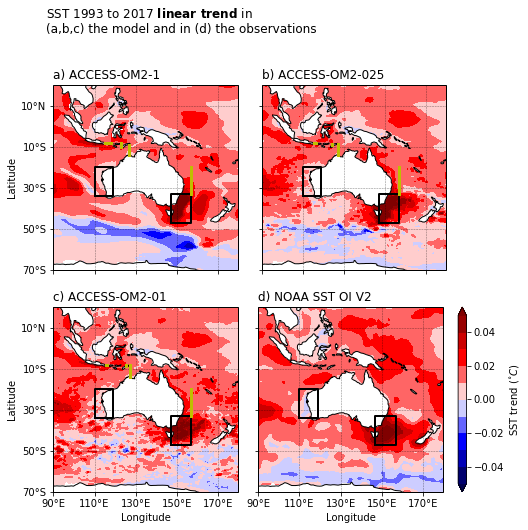

In [9]:
def savefigure(fname):
    output_dir = '/home/561/erd561/figures/Australia/'
    fig_name = nb_name[:-6]
    fig_dir = output_dir + fig_name

    output_ls = os.listdir(output_dir)
    if fig_name not in output_ls:
        os.mkdir(fig_dir) 
    plt.savefig(os.path.join(fig_dir, fig_name[0:4]+fname+'.png'), 
                dpi=300, bbox_inches="tight")


land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='white',
                                    linewidth=1)

# fig = plt.figure(1, figsize=(7.48,9.06)) 
fig = plt.figure(1, figsize=(9.06,7.48)) 
matplotlib.rcParams.update({'font.size': 10})    

plt.suptitle(
    r'SST 1993 to 2017 $\bf{linear\ trend}$ in ' +
    '\n(a,b,c) the model and in (d) the observations',
    x=0.2,y=1.025, ha='left')

row=2
col=2

ax = plt.subplot(row, col, 1, projection=ccrs.PlateCarree())
levels=arange(-0.05,0.05,0.01)
cmap = plt.cm.seismic
sst_1_bias = sst_1_slopes_mod.values
plt.contourf(sst_1_obs.lon_1+360, sst_1_obs.lat_1, 
             sst_1_bias, 
             levels=levels, extend='both', 
             cmap=cmap, transform=ccrs.PlateCarree())
# plt.colorbar(orientation='vertical')
ax.set_title('a) ACCESS-OM2-1', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_xlabel('Longitude')
ax.set_xticklabels('')
ax.set_ylabel('Latitude')
# ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
plt.plot(
    [lonW_LC, lonE_LC, lonE_LC, lonW_LC, lonW_LC],
    [latS_LC, latS_LC, latN_LC, latN_LC, latS_LC], 'k', linewidth=2)
plt.plot(
    [lonW_EAC, lonE_EAC, lonE_EAC, lonW_EAC, lonW_EAC],
    [latS_EAC, latS_EAC, latN_EAC, latN_EAC, latS_EAC], 'k', linewidth=2)
plt.plot(
    [straits_1deg['Lombok Strait'][0]+360, straits_1deg['Lombok Strait'][1]+360],
    [straits_1deg['Lombok Strait'][2], straits_1deg['Lombok Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_1deg['Ombai Strait'][0]+360, straits_1deg['Ombai Strait'][1]+360],
    [straits_1deg['Ombai Strait'][2], straits_1deg['Ombai Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_1deg['Timor Strait'][0]+360, straits_1deg['Timor Strait'][1]+360],
    [straits_1deg['Timor Strait'][2], straits_1deg['Timor Strait'][3]], 'y', linewidth=3)
plt.plot(
    [lonE_EAC, lonE_EAC],
    [latN_EAC, latN_157E], 'y', linewidth=3)


ax = plt.subplot(row, col, 2, projection=ccrs.PlateCarree())
# levels=arange(0,30,2.5)
# cmap = plt.cm.rainbow
sst_025_bias = sst_025_slopes_mod.values
plt.contourf(sst_025_obs.lon_025+360, sst_025_obs.lat_025, 
             sst_025_bias, 
             levels=levels, extend='both',
             cmap=cmap, transform=ccrs.PlateCarree())
# plt.colorbar(orientation='vertical', label='SST bias ($^{\circ}C$)')
ax.set_title('b) ACCESS-OM2-025', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_xlabel('Longitude')
ax.set_xticklabels('')
# ax.set_ylabel('Latitude')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
plt.plot(
    [lonW_LC, lonE_LC, lonE_LC, lonW_LC, lonW_LC],
    [latS_LC, latS_LC, latN_LC, latN_LC, latS_LC], 'k', linewidth=2)
plt.plot(
    [lonW_EAC, lonE_EAC, lonE_EAC, lonW_EAC, lonW_EAC],
    [latS_EAC, latS_EAC, latN_EAC, latN_EAC, latS_EAC], 'k', linewidth=2)
plt.plot(
    [straits_025deg['Lombok Strait'][0]+360, straits_025deg['Lombok Strait'][1]+360],
    [straits_025deg['Lombok Strait'][2], straits_025deg['Lombok Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_025deg['Ombai Strait'][0]+360, straits_025deg['Ombai Strait'][1]+360],
    [straits_025deg['Ombai Strait'][2], straits_025deg['Ombai Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_025deg['Timor Strait'][0]+360, straits_025deg['Timor Strait'][1]+360],
    [straits_025deg['Timor Strait'][2], straits_025deg['Timor Strait'][3]], 'y', linewidth=3)
plt.plot(
    [lonE_EAC, lonE_EAC],
    [latN_EAC, latN_157E], 'y', linewidth=3)


ax = plt.subplot(row, col, 3, projection=ccrs.PlateCarree())
# levels=arange(0,30,2.5)
# cmap = plt.cm.rainbow
sst_01_bias = sst_01_slopes_mod.values
plt.contourf(sst_01_obs.lon_01+360, sst_01_obs.lat_01, 
             sst_01_bias, 
             levels=levels, extend='both',
             cmap=cmap, transform=ccrs.PlateCarree())
# plt.colorbar(orientation='vertical')
ax.set_title('c) ACCESS-OM2-01', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
ax.set_ylabel('Latitude')
# ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
plt.plot(
    [lonW_LC, lonE_LC, lonE_LC, lonW_LC, lonW_LC],
    [latS_LC, latS_LC, latN_LC, latN_LC, latS_LC], 'k', linewidth=2)
plt.plot(
    [lonW_EAC, lonE_EAC, lonE_EAC, lonW_EAC, lonW_EAC],
    [latS_EAC, latS_EAC, latN_EAC, latN_EAC, latS_EAC], 'k', linewidth=2)
plt.plot(
    [straits_01deg['Lombok Strait'][0]+360, straits_01deg['Lombok Strait'][1]+360],
    [straits_01deg['Lombok Strait'][2], straits_01deg['Lombok Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_01deg['Ombai Strait'][0]+360, straits_01deg['Ombai Strait'][1]+360],
    [straits_01deg['Ombai Strait'][2], straits_01deg['Ombai Strait'][3]], 'y', linewidth=3)
plt.plot(
    [straits_01deg['Timor Strait'][0]+360, straits_01deg['Timor Strait'][1]+360],
    [straits_01deg['Timor Strait'][2], straits_01deg['Timor Strait'][3]], 'y', linewidth=3)
plt.plot(
    [lonE_EAC, lonE_EAC],
    [latN_EAC, latN_157E], 'y', linewidth=3)


ax = plt.subplot(row, col, 4, projection=ccrs.PlateCarree())
# levels=arange(-0.05,0.05,0.01)
# cmap = plt.cm.seismic
plt.contourf(sst_obs.lon+360, sst_obs.lat, 
             sst_slopes_obs, 
             levels=levels, extend='both',
             cmap=cmap, transform=ccrs.PlateCarree())
plt.colorbar(orientation='vertical', label='SST trend ($^{\circ}C$)')
ax.set_title('d) NOAA SST OI V2', loc='left')
ax.set_extent([90, 180, -70, 20], crs=ccrs.PlateCarree())
ax.set_xticks(arange(90, 180, 20), crs=ccrs.PlateCarree())
ax.set_yticks(arange(-70, 20, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel('Longitude')
# ax.set_xticklabels('')
# ax.set_ylabel('Latitude')
ax.set_yticklabels('')
ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.add_feature(land_50m)
plt.plot(
    [lonW_LC, lonE_LC, lonE_LC, lonW_LC, lonW_LC],
    [latS_LC, latS_LC, latN_LC, latN_LC, latS_LC], 'k', linewidth=2)
plt.plot(
    [lonW_EAC, lonE_EAC, lonE_EAC, lonW_EAC, lonW_EAC],
    [latS_EAC, latS_EAC, latN_EAC, latN_EAC, latS_EAC], 'k', linewidth=2)
# plt.plot(
#     [straits_1deg['Lombok Strait'][0]+360, straits_1deg['Lombok Strait'][1]+360],
#     [straits_1deg['Lombok Strait'][2], straits_1deg['Lombok Strait'][3]], 'y', linewidth=3)
# plt.plot(
#     [straits_1deg['Ombai Strait'][0]+360, straits_1deg['Ombai Strait'][1]+360],
#     [straits_1deg['Ombai Strait'][2], straits_1deg['Ombai Strait'][3]], 'y', linewidth=3)
# plt.plot(
#     [straits_1deg['Timor Strait'][0]+360, straits_1deg['Timor Strait'][1]+360],
#     [straits_1deg['Timor Strait'][2], straits_1deg['Timor Strait'][3]], 'y', linewidth=3)
# plt.plot(
#     [lonE_EAC, lonE_EAC],
#     [latN_EAC, latN_157E], 'y', linewidth=3)


wspace = -0.3
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=None)

savefigure('linear_trend_area')